# Alzheimer MRI Preprocessed Dataset
Preprocessed Alzheimer Disease MRI (Magnetic Resonance Imaging) from  several websites/hospitals/public repositories: [OASIS](https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers), [ADNI](https://adni.loni.usc.edu/), [alzheimers.net](https://www.alzheimers.net/), [BRFSS](https://catalog.data.gov/dataset/alzheimers-disease-and-healthy-aging-data), [IEEE](https://ieeexplore.ieee.org/document/9521165), [scientific reports](https://www.nature.com/articles/s41598-020-79243-9), [CORDIS](https://cordis.europa.eu/article/id/429468-the-final-epad-dataset-is-now-available-on-the-alzheimer-s-disease-workbench)

---

* #### 데이터셋 : [Kaggle](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset?datasetId=2029496&sortBy=voteCount)
    
* #### 참고 : 
    * 의료 이미지 데이터(.nifti) : [kaggle notebook](https://www.kaggle.com/code/tomdomers/oasis-brain-analysis), 
    * 이미지 전처리 (두개골 지우기) : [kaggle notebook](https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16), [pyimagesearch blog](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)  
    * D.L Model : [kaggle notebook](https://www.kaggle.com/code/jeongwoopark/alzheimer-detection-and-classification-98-7-acc)
  
* #### 데이터 설명 :
    * 출처 : 상단의 웹사이트/병원/공공데이터
    * 포맷 : 데이터셋은 전처리된 MRI이미지로, 모두 128 x 128 픽셀로 조정되어있음.
    * 구성 : 데어터셋은 총 4개의 클래스로 나뉘어져 있음.  
        * 비치매 (3200개 이미지)  
        * 매우 경증 치매 (2240개 이미지)    
        * 경도 치매 (896개 이미지)  
        * 중등도 치매 (64개 이미지)
---

## Presetting

### 1. Libraries

In [1]:
# !pip install koreanize_matplotlib
# !pip install nibabel
# !pip install opencv-python
# !pip install nilearn
# !pip install imutils

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import koreanize_matplotlib
import seaborn as sns

%matplotlib inline

In [3]:
# 파일 경로 관련
from glob import glob
import os

In [4]:
# 이미지 처리 관련
from PIL import Image
import nibabel as nib
import cv2
from skimage import transform
from scipy.ndimage import rotate
import nilearn.plotting as plotting
import imutils

In [5]:
# 딥러닝 모델 관련
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory

### 2. Dataset Load

In [6]:
# 파일 경로 확인 > '분류명/파일명' 형태로 되어있음.
glob('../Preprocessed Alzheimer MRI/*')

['../Preprocessed Alzheimer MRI/Very_Mild_Demented',
 '../Preprocessed Alzheimer MRI/Moderate_Demented',
 '../Preprocessed Alzheimer MRI/Mild_Demented',
 '../Preprocessed Alzheimer MRI/Non_Demented']

In [7]:
# root_dir 설정 > 하위목록 확인
root_dir = '../Preprocessed Alzheimer MRI/'
os.listdir(root_dir)

['Very_Mild_Demented',
 'Moderate_Demented',
 'Mild_Demented',
 'Non_Demented',
 '.ipynb_checkpoints']

In [8]:
# root_dir 경로 안에 있는 폴더마다 img가져오고, 폴더명을 y값으로 저장
img_list = []
folder_list = []
for folder_name in os.listdir(root_dir):
    for img in os.listdir(root_dir + folder_name):
        img_list.append(Image.open(f'{root_dir + folder_name}/{img}'))  # img 가져오기
        folder_list.append(folder_name)  # folder_name을 y값으로 저장

In [9]:
print(pd.Series(folder_list).value_counts())
print('Total : ', pd.Series(folder_list).value_counts().sum())

Non_Demented          3200
Very_Mild_Demented    2240
Mild_Demented          896
Moderate_Demented       64
dtype: int64
Total :  6400


In [10]:
# group명 변경하기
# 기존 : 4개 그룹 => 변경 : 3개 그룹(non, mild, moderate)
group_list = []
for folder in folder_list :
    if folder == 'Non_Demented': 
        group_list.append('non')
    elif folder == 'Very_Mild_Demented': 
        group_list.append('mild')
    elif (folder == 'Mild_Demented' or folder == 'Moderate_Demented'): 
        group_list.append('moderate')

group_counts = pd.Series(group_list).value_counts()
print(group_counts)
print('Total : ', group_counts.sum())

non         3200
mild        2240
moderate     960
dtype: int64
Total :  6400


### 3. Dataset 확인

총 4개의 그룹으로 나누어져 있음. (Moderate_Demented 중증 치매 환자의 데이터는 전체 1% 밖에 되지 않음.)  
뇌는 복잡한 구조여서 평균적인 이미지를 만들어서는 그룹간의 차이를 구별하기 어려움.

non         3200
mild        2240
moderate     960
dtype: int64


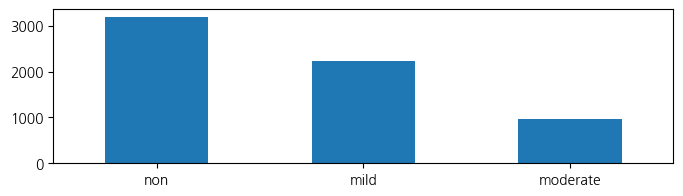

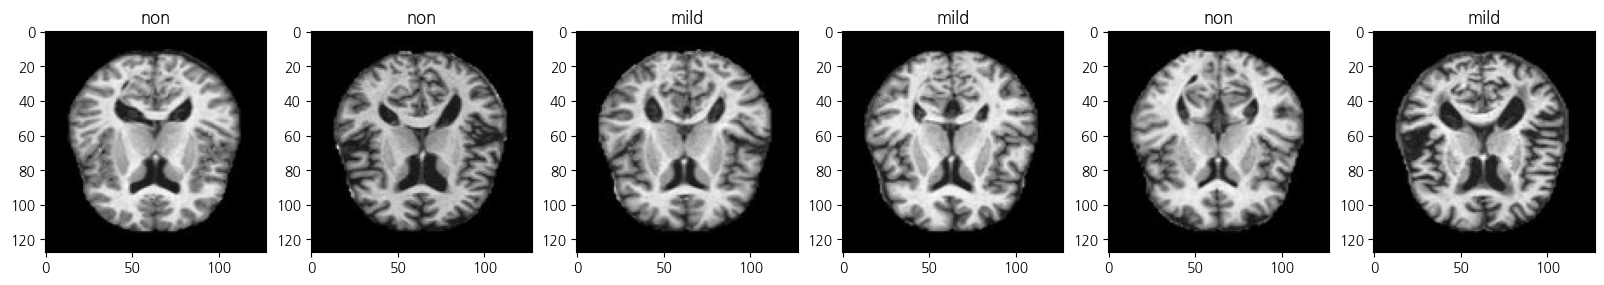

In [11]:
# group_list에 그룹별로 잘 나뉘었는지 확인
print(pd.Series(group_list).value_counts())
plt.figure(figsize=(8, 2))
pd.Series(group_list).value_counts().plot(kind='bar', rot=0);

# img_list에 담긴 이미지 파일 확인
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
for i in range(len(axes)):
    num = np.random.randint(0, group_counts.sum())
    axes[i].imshow(img_list[num], cmap='gray')
    axes[i].set_title(group_list[num])

그룹별 평균적인 뇌 이미지


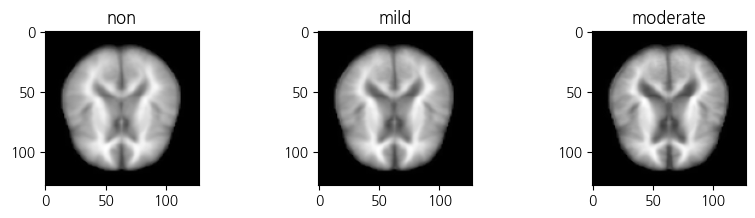

In [12]:
fig, axes = plt.subplots(1, group_counts.nunique(), figsize=(10, 2))
print('그룹별 평균적인 뇌 이미지')
for i in range(group_counts.nunique()):
    group_name = pd.Series(group_list).value_counts().index[i]
    img_arrays = [np.array(img_group[0]) for img_group in list(zip(img_list, group_list))
             if img_group[1] == group_name]
    img_arrays = np.array(img_arrays) / 255
    mean_img = np.mean(np.stack(img_arrays), axis=0)
    axes[i].imshow(mean_img, cmap='gray')
    axes[i].set_title(group_name)

## Deep-Learning 모델

### 4. Preprocessing

In [13]:
# X값으로 사용할 데이터 (위의 img를 np.array형태로 변환해서 저장) 
X = [np.array(img) for img in img_list]

# 이미지 array의 값을 0~1로 정규화
X = np.array(X)/255
X.shape

(6400, 128, 128)

In [14]:
# group_list의 group이름을 숫자로 인코딩 > y에 담아주기 (정답값)
y = []
for group_name in group_list :
    if group_name=='non': y.append(0)
    elif group_name=='mild': y.append(1)
    elif group_name=='moderate' : y.append(2)
    
y = to_categorical(y)
y.shape

(6400, 3)

In [15]:
# 모델에 넣을 수 있는 형태로 변환
# Input 0 of layer "conv2d" is incompatible with the layer: 
# expected min_ndim=4, found ndim=3. Full shape received: (None, 128, 128)
X = X.reshape(6400, 128, 128, 1)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4800, 128, 128, 1), (1600, 128, 128, 1), (4800, 3), (1600, 3))

### 5. Model 만들기

In [16]:
# CNN 모델 생성
cnn=Sequential()

#initially 64 convolution nodes
cnn.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=X_train.shape[1:]))
#add a Max Pooling layer
cnn.add(MaxPooling2D())

#another 32 convolution nodes
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())

#Add 32 convolutions
cnn.add(Conv2D(32,(2,2),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())

#Flatten before adding fully connected layer
cnn.add(Flatten())

#Add a hidden layer with 100 nodes
cnn.add(Dense(100,activation='relu'))

#Add another hidden layer with 50 nodes
cnn.add(Dense(50,activation='relu'))

# Add final ouptput layer : 클래스의 개수대로 만들어줌 (다중분류 softmax)
cnn.add(Dense(group_counts.nunique(), activation='softmax'))

2023-05-05 12:33:09.531010: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 12:33:10.191015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1553] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14445 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:be:00.0, compute capability: 7.0


In [17]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

### 6. Model 학습

In [18]:
# compile
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# 모델 훈련
history = cnn.fit(X_train, y_train, 
                  validation_split=0.2,
                  shuffle=True,
#                   class_weight=,
                  epochs=20,
                 )

Epoch 1/20


2023-05-05 12:33:12.364220: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


120/120 [==============================] - 3s 11ms/step - loss: 0.9782 - accuracy: 0.4987 - val_loss: 0.9036 - val_accuracy: 0.5292
Epoch 2/20
120/120 [==============================] - 1s 8ms/step - loss: 0.8796 - accuracy: 0.5536 - val_loss: 0.9097 - val_accuracy: 0.5385
Epoch 3/20
120/120 [==============================] - 1s 8ms/step - loss: 0.8059 - accuracy: 0.6083 - val_loss: 0.8501 - val_accuracy: 0.5427
Epoch 4/20
120/120 [==============================] - 1s 8ms/step - loss: 0.6822 - accuracy: 0.6841 - val_loss: 0.6950 - val_accuracy: 0.6844
Epoch 5/20
120/120 [==============================] - 1s 8ms/step - loss: 0.5200 - accuracy: 0.7690 - val_loss: 0.5108 - val_accuracy: 0.7865
Epoch 6/20
120/120 [==============================] - 1s 8ms/step - loss: 0.3678 - accuracy: 0.8443 - val_loss: 0.4446 - val_accuracy: 0.8375
Epoch 7/20
120/120 [==============================] - 1s 8ms/step - loss: 0.2085 - accuracy: 0.9211 - val_loss: 0.3401 - val_accuracy: 0.8719
Epoch 8/20
120/1

### 7. Model 평가

In [20]:
def result_summary(model, X_test, y_test):
    """
    model, X_test, y_test를 입력하면 confusion matrix, classification report를 보여주고
    y_pred_val을 리턴하는 함수
    """
    # X_test에 대한 정답값 예측
    y_pred = model.predict(X_test, verbose=0);
    
    # argmax로 클래스 중 정답값 선택
    y_test_val = [np.argmax(y) for y in y_test]
    y_pred_val = [np.argmax(y) for y in y_pred]

    # Classification Report
    clr = classification_report(y_test_val, y_pred_val)
    print("Classification Report\n----------------------\n", clr)

    # Confusion Matrix
    cm = confusion_matrix(y_test_val, y_pred_val)
    print("\n\nConfusion Matrix\n----------------------")
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', linewidths=10)
    plt.xlabel("Predicted")
    plt.ylabel("Actual");

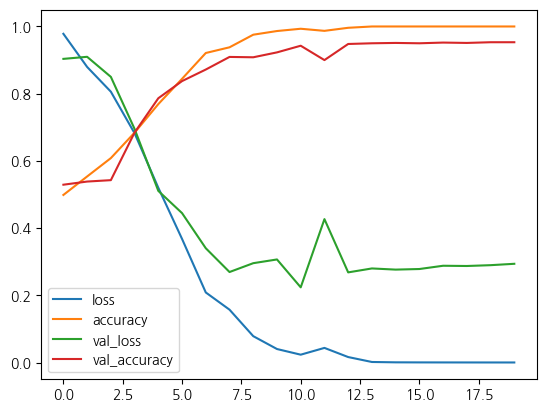

In [21]:
pd.DataFrame(history.history).plot();

Classification Report
----------------------
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       773
           1       0.95      0.94      0.94       586
           2       0.95      0.91      0.93       241

    accuracy                           0.95      1600
   macro avg       0.95      0.94      0.94      1600
weighted avg       0.95      0.95      0.95      1600



Confusion Matrix
----------------------


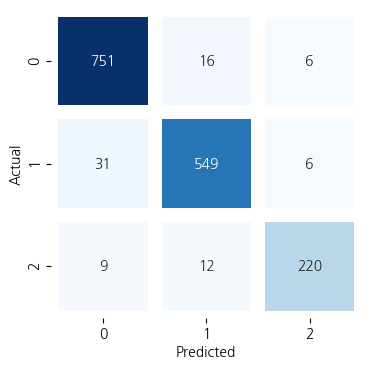

In [22]:
result_summary(cnn, X_test, y_test)

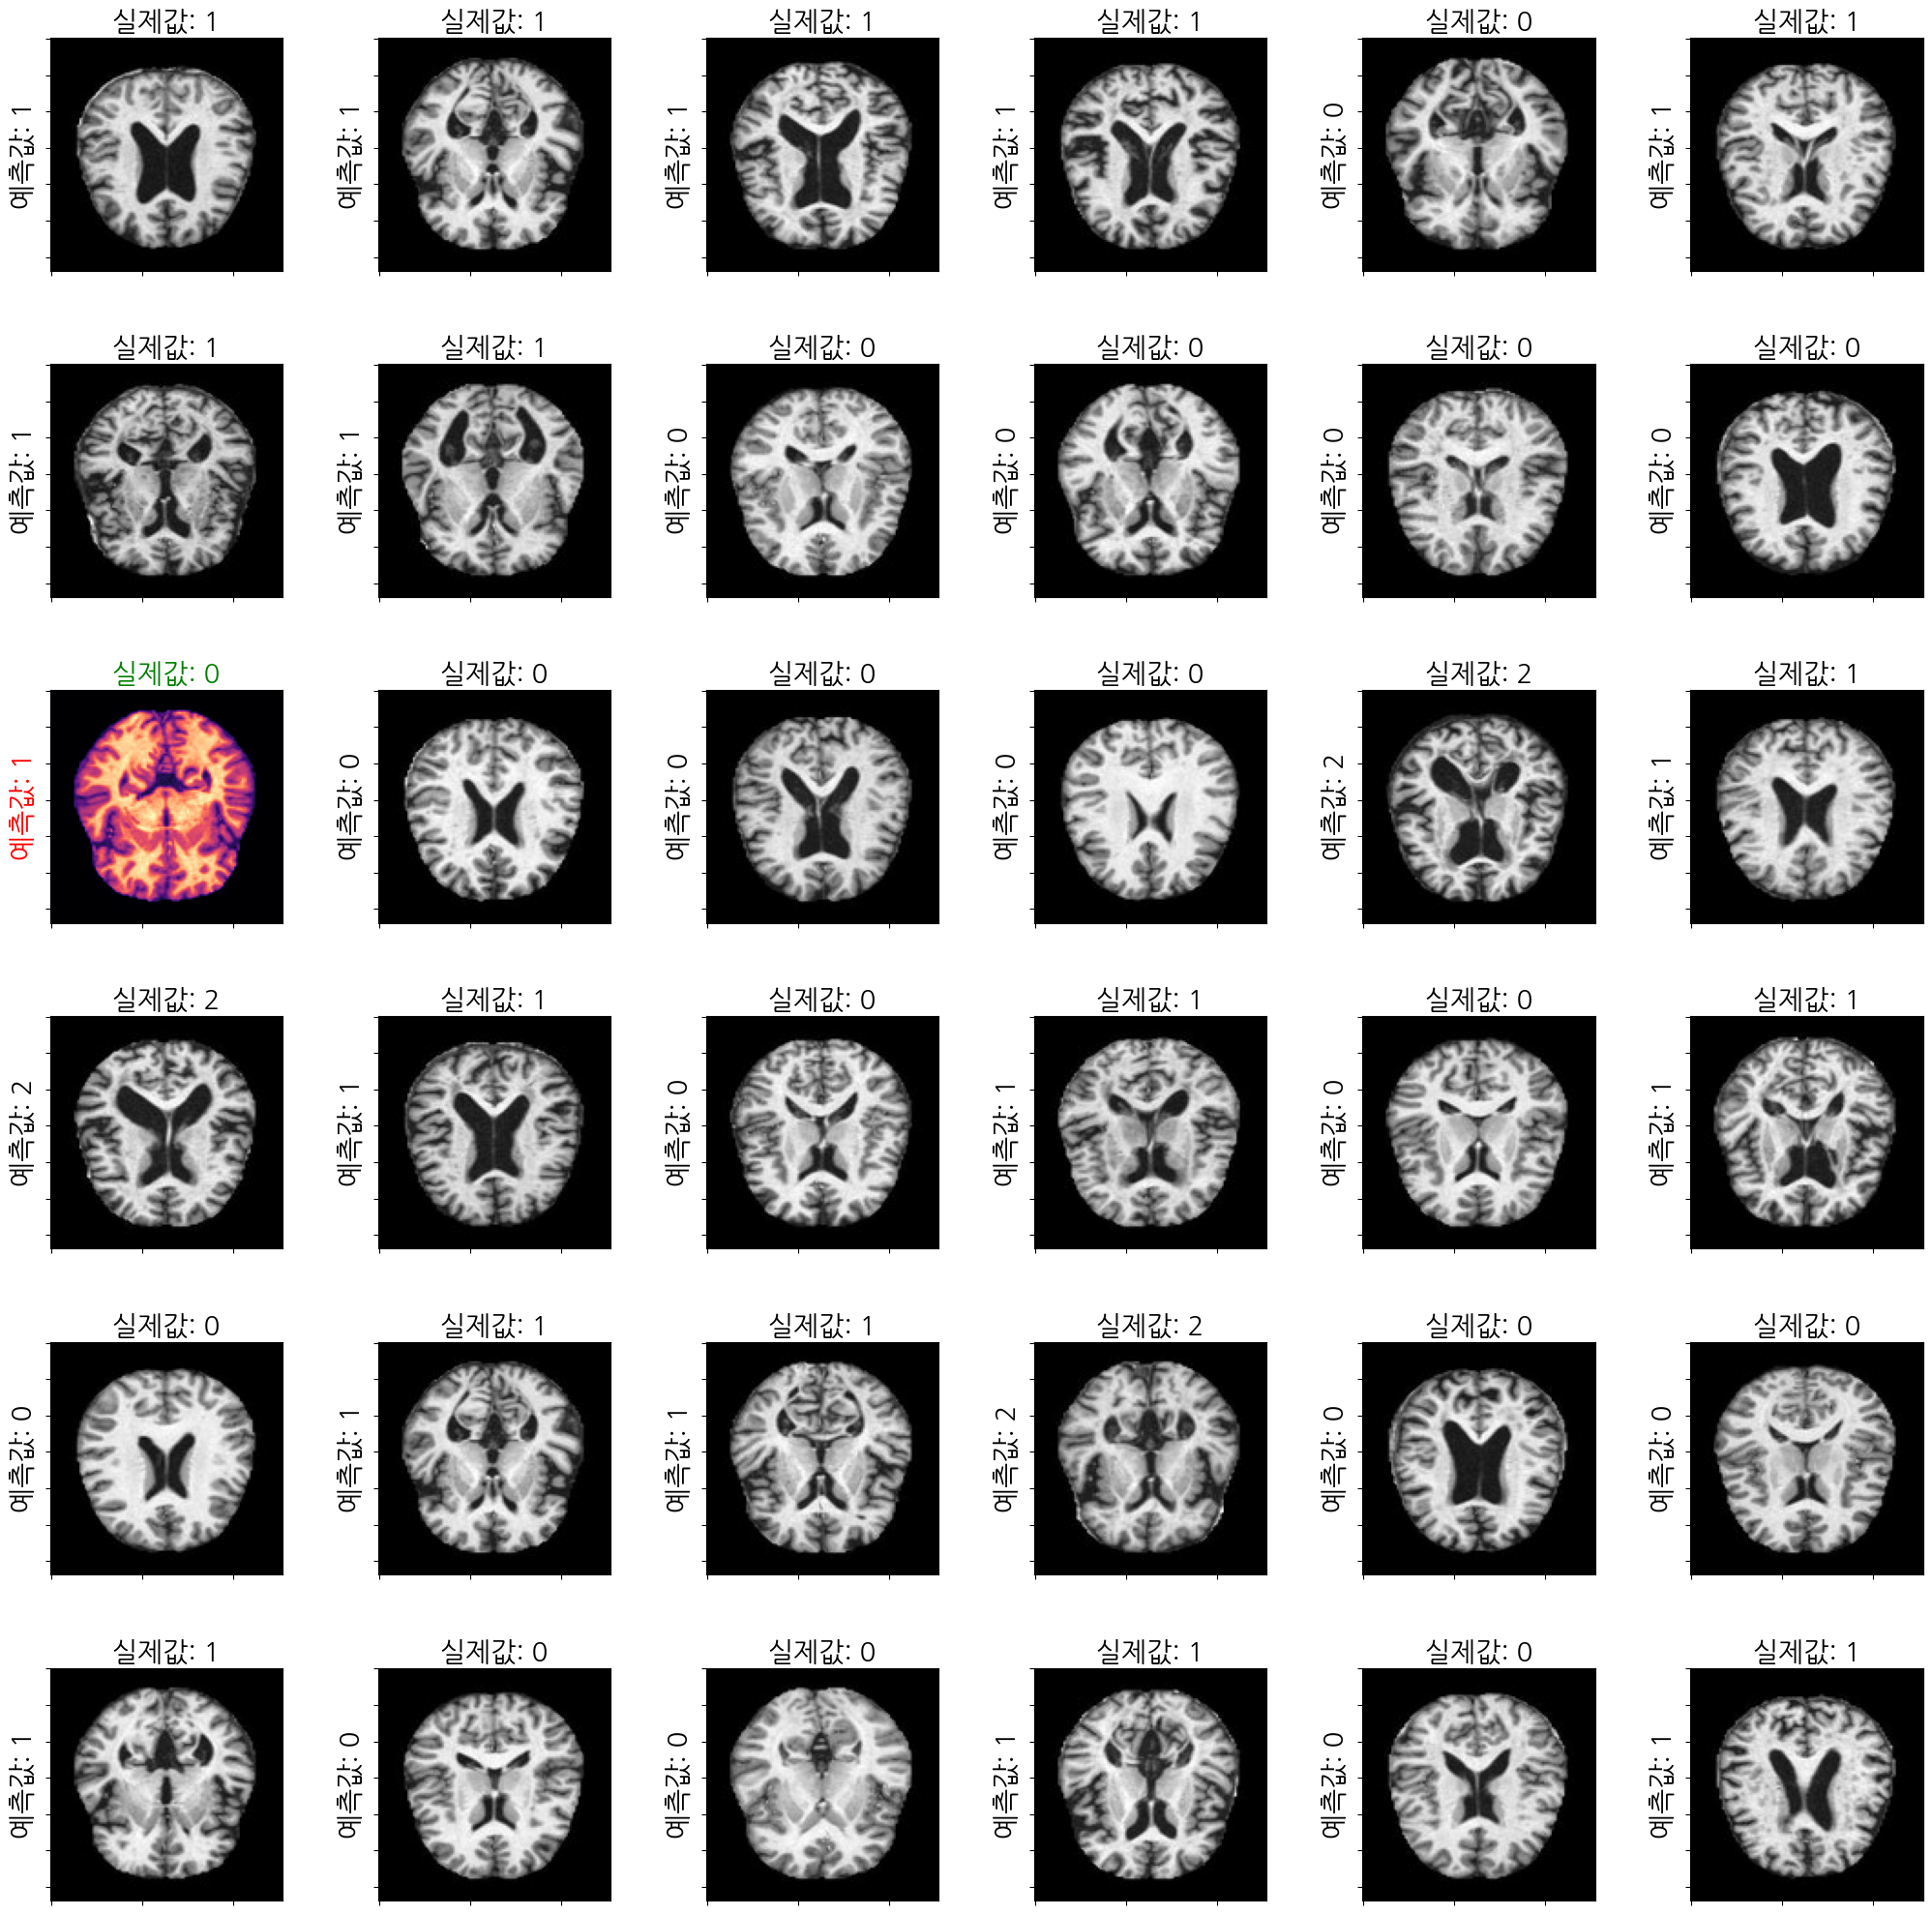

In [23]:
# 예측결과 예시
fig, axes = plt.subplots(6, 6, figsize=(25, 25))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
w = (axes.shape)[0]
h = (axes.shape)[1]

for i in range(0, w*h):
    # 랜덤숫자 만들기
    rand = np.random.randint(0, len(X_test))
    
    # X_test, y_test에서 rand번째 값 가져오기
    y_pred = cnn.predict(X_test[rand].reshape(1, 128, 128, 1), verbose=0)
    y_pred_val = np.argmax(y_pred)
    y_test_val = np.argmax(y_test[rand])
    
    # actual, predicted, img 
    axes[i//w, i%w].set_title(f'실제값: {y_test_val}', fontsize=20, 
                              color='green' if y_test_val!=y_pred_val else 'black')
    axes[i//w, i%w].set_ylabel(f'예측값: {y_pred_val}', fontsize=20, 
                              color='red' if y_test_val!=y_pred_val else 'black')
    axes[i//w, i%w].imshow(X_test[rand], 
                              cmap='gray' if y_test_val==y_pred_val else 'magma')
    axes[i//w, i%w].set_xticklabels([])
    axes[i//w, i%w].set_yticklabels([])

# OASIS-2

## 1. nifti 데이터 로드

In [24]:
dir_path = sorted(glob('../OASIS-2 dataset/*'))

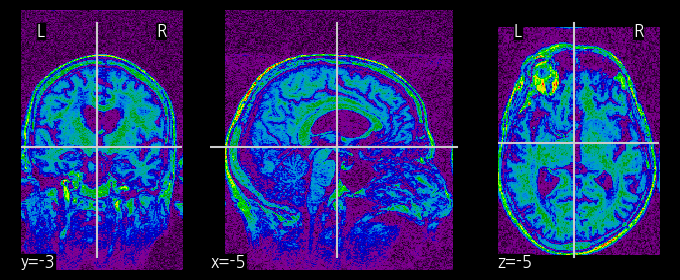

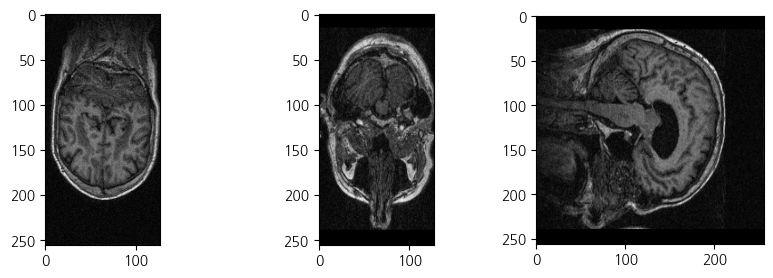

In [25]:
# 이미지 파일 경로
filepath = '../OASIS-2 dataset/OAS2_0017_MR3/mpr-4.nifti.img'

# 이미지 파일 불러오기
img = nib.load(filepath)
plotting.plot_epi(img)

# 데이터 얻기
data = img.get_fdata()

# 이미지 시각화
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(data[70, :, :], cmap='gray')
axes[1].imshow(data[:, 70, :], cmap='gray')
axes[2].imshow(data[:, :, 70], cmap='gray');


## 2. 이미지 데이터 전처리

### 이미지 비율 맞추기 (slice, resize, fill)

In [168]:
# # nifti.img 파일 읽어오기
# file = nib.load(filepath)
# img_data = file.get_fdata()

# # 이미지 처리 과정 (OASIS-2 데이터셋을 preprocessed처럼 만들기)
# fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# # slicing
# sliced_img = img_data[:, 140, :]
# axes[0,0].imshow(sliced_img, cmap='gray')
# axes[0,0].set_title(f'1. sliced_img, {sliced_img.shape}')

# # resizing
# resized_img = transform.resize(sliced_img, (128, 64, 1), anti_aliasing=True)
# axes[0,1].imshow(resized_img, cmap='gray')
# axes[0,1].set_title(f'2. resized_img: {resized_img.shape}')

# # filling
# h, w, _ = resized_img.shape
# filled_img = np.zeros((128, 80, 1))
# y = (filled_img.shape[0] - h) // 2
# x = (filled_img.shape[1] - w) // 2
# filled_img[y:y+h, x:x+w, :] = resized_img
# axes[1,0].imshow(filled_img, cmap='gray')
# axes[1,0].set_title(f'3. filled_img: {filled_img.shape}')

# # resizing
# retouched_img = transform.resize(filled_img, (128, 128, 1), anti_aliasing=True)
# axes[1,1].imshow(retouched_img, cmap='gray')
# axes[1,1].set_title(f'4. retouched_img: {retouched_img.shape}')

### 두개골 지우기

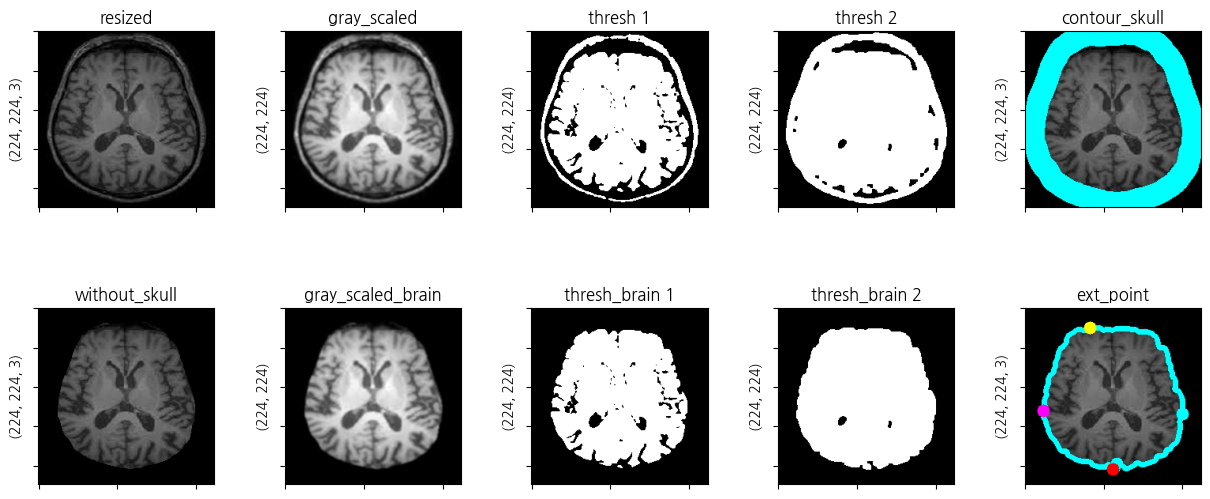

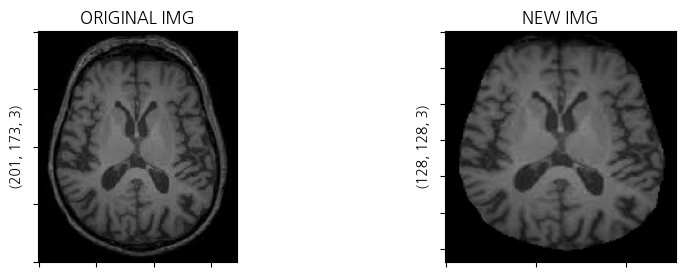

In [255]:
# 이미지 전처리 과정 : 두개골 지우기 > 뇌에 맞춰서 이미지 크롭 > 리사이징

img_size = (224,224)
output_size = (128, 128)
line_width = 28
margins = 10


def make_subplot(img, title, i) :
    """
    이미지, shape, title을 axes[i] subplot에 보여주는 함수
    """
    axes[i].imshow(img, cmap='gray')
    axes[i].set_ylabel(img.shape)
    axes[i].set_title(title)
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    

# presetting the img
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(wspace=0.4, hspace=0.5)

# 0. img로드 > resizing
original_img = cv2.imread('example.jpg')
resized = cv2.resize(original_img, dsize=img_size, interpolation=cv2.INTER_CUBIC)  # 이미지 보간방법
make_subplot(resized, 'resized', (0, 0))

# 1. gray_scaling
gray_scaled = cv2.cvtColor(resized, code=cv2.COLOR_RGB2GRAY)  # RGB색상공간을 gray scale로 변환 (명도에 집중하게 됨)
gray_scaled = cv2.GaussianBlur(gray_scaled, ksize=(5, 5), sigmaX=0)  # 가우시안필터 적용 : 노이즈 제거
make_subplot(gray_scaled, 'gray_scaled', (0, 1))

# skull contour removal
# 2, 3. thresh : threshold 설정 > erosion + dilation > 노이즈 제거 (순서나 iterations에 따라 달라짐)
thresh = cv2.threshold(gray_scaled, thresh=45, maxval=255, 
                       type=cv2.THRESH_BINARY)[1]  # thresh : 임계치를 기준으로 흑백(binary)이미지로 변형
make_subplot(thresh, 'thresh 1', (0, 2))
thresh = cv2.dilate(thresh, None, iterations=3)  # dilate : 흰색 픽셀을 확장 
thresh = cv2.erode(thresh, None, iterations=1)  # erode : 검은색 픽셀을 축소
make_subplot(thresh, 'thresh 2', (0, 3))

# 4. contour_skull : 지울 범위 확인
contours = cv2.findContours(thresh.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)  # contours 찾기
contours = imutils.grab_contours(contours)  # tuple값을 list형태로 간결하게
contour = max(contours, key=cv2.contourArea)  # 찾은 contours 중에서 max값
contour_skull = cv2.drawContours(image=resized.copy(), # 원본 이미지 위에 contour 표시하기
                               contours=[contour],  # contour를 리스트 형태로 해주지 않으면 선이 끊어지게 나옴. 
                               contourIdx=-1,  # contourIdx는 0, -1 중에 
                               color=(0, 255, 255), thickness=line_width)  # 검정색으로 25만큼 thinckness로 덮어버리기
make_subplot(contour_skull, 'contour_skull', (0, 4))

# 5. without_skull : 위에서 확인한 라인만큼 지우기
without_skull = cv2.drawContours(image=resized.copy(), contours=[contour], contourIdx=-1, 
                                 color=(0, 0, 0), thickness=line_width)  # 검정색으로 덮어버리기
make_subplot(without_skull, 'without_skull', (1, 0))


# resizing the brain-only-img
# 6. gray_scaling
gray_scaled_brain = cv2.cvtColor(without_skull, code=cv2.COLOR_RGB2GRAY)  # gray scale로 변환 (명도에 집중하게 됨)
gray_scaled_brain = cv2.GaussianBlur(gray_scaled_brain, ksize=(5, 5), sigmaX=0)  # 가우시안필터 적용 : 노이즈 제거
make_subplot(gray_scaled_brain, 'gray_scaled_brain', (1, 1))

# 7. threshold
thresh_brain = cv2.threshold(gray_scaled_brain, thresh=45, maxval=255, type=cv2.THRESH_BINARY)[1] 
make_subplot(thresh_brain, 'thresh_brain 1', (1, 2))
thresh_brain = cv2.dilate(thresh_brain, None, iterations=3) 
thresh_brain = cv2.erode(thresh_brain, None, iterations=1) 
make_subplot(thresh_brain, 'thresh_brain 2', (1, 3))

# 8. contour 찾기
contours_brain = cv2.findContours(thresh_brain.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
contours_brain = imutils.grab_contours(contours_brain)  
contour_brain = max(contours_brain, key=cv2.contourArea) 
contour_brain_img = cv2.drawContours(image=without_skull.copy(), contours=[contour_brain], contourIdx=-1,  
                               color=(0, 255, 255), thickness=5) 

# 9. extreme point 찾기
x좌표, y좌표 = contour_brain[:, :, 0], contour_brain[:, :, 1]
left_point = tuple(contour_brain[x좌표.argmin()][0])
right_point = tuple(contour_brain[x좌표.argmax()][0])
top_point = tuple(contour_brain[y좌표.argmax()][0])
bottom_point = tuple(contour_brain[y좌표.argmin()][0])

ext_point = cv2.circle(contour_brain_img.copy(), center=left_point, radius=8, color=(255, 0, 255), thickness=-1)
ext_point = cv2.circle(ext_point.copy(), center=right_point, radius=8, color=(0, 255, 255), thickness=-1)
ext_point = cv2.circle(ext_point.copy(), center=top_point, radius=8, color=(255, 0, 0), thickness=-1)
ext_point = cv2.circle(ext_point.copy(), center=bottom_point, radius=8, color=(255, 255, 0), thickness=-1)
make_subplot(ext_point, 'ext_point', (1, 4))


# ----------------------------------------------------------------
# 10. ext_point를 기준으로 이미지 crop
cropped_img = without_skull[bottom_point[1]-margins : top_point[1]+margins, 
                        left_point[0]-margins : right_point[0]+margins].copy()

new_img = cv2.resize(cropped_img, dsize=output_size, interpolation=cv2.INTER_CUBIC)


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
make_subplot(original_img, 'ORIGINAL IMG', 0)
make_subplot(new_img, 'NEW IMG', 1)

### 위의 전처리 과정을 함수로 만들기

In [256]:
def preprocess_img(original_img, output_size):
    """
    뇌 이미지에서 두개골 제거, crop해서 output_size로 resize된 new_img를 리턴하는 함수
    """
    line_width = 28
    margins = 10
    
    resized = cv2.resize(original_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    
    gray_scaled = cv2.cvtColor(resized, code=cv2.COLOR_RGB2GRAY)
    gray_scaled = cv2.GaussianBlur(gray_scaled, ksize=(5, 5), sigmaX=0)

    thresh = cv2.threshold(gray_scaled, thresh=45, maxval=255, type=cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=3)
    thresh = cv2.erode(thresh, None, iterations=1)
    
    contours = cv2.findContours(thresh.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    contour = max(imutils.grab_contours(contours), key=cv2.contourArea)
    without_skull = cv2.drawContours(image=resized.copy(), contours=[contour], 
                                     contourIdx=-1, color=(0, 0, 0), thickness=line_width)

    gray_scaled_brain = cv2.cvtColor(without_skull, code=cv2.COLOR_RGB2GRAY)
    gray_scaled_brain = cv2.GaussianBlur(gray_scaled_brain, ksize=(5, 5), sigmaX=0)
    
    thresh_brain = cv2.threshold(gray_scaled_brain, thresh=45, maxval=255, type=cv2.THRESH_BINARY)[1] 
    thresh_brain = cv2.dilate(thresh_brain, None, iterations=3) 
    thresh_brain = cv2.erode(thresh_brain, None, iterations=1) 
    
    contours_brain = cv2.findContours(thresh_brain.copy(), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    contours_brain = imutils.grab_contours(contours_brain)  
    contour_brain = max(contours_brain, key=cv2.contourArea) 
    contour_brain_img = cv2.drawContours(image=without_skull.copy(), contours=[contour_brain], contourIdx=-1,  
                                   color=(0, 255, 255), thickness=5) 
    
    x좌표, y좌표 = contour_brain[:, :, 0], contour_brain[:, :, 1]
    left_point = tuple(contour_brain[x좌표.argmin()][0])
    right_point = tuple(contour_brain[x좌표.argmax()][0])
    top_point = tuple(contour_brain[y좌표.argmax()][0])
    bottom_point = tuple(contour_brain[y좌표.argmin()][0])

    cropped_img = without_skull[bottom_point[1]-margins : top_point[1]+margins, 
                                left_point[0]-margins : right_point[0]+margins].copy()
    new_img = cv2.resize(cropped_img, dsize=output_size, interpolation=cv2.INTER_CUBIC)    
    
    return new_img

### 함수 테스트 (OASIS-2 의 데이터) => Good

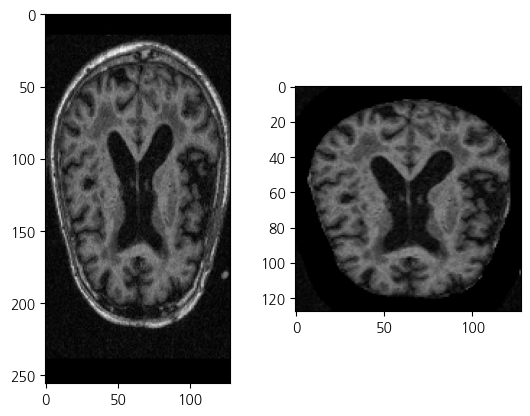

In [257]:
# nifti.img 에서 원하는 데이터만 저장하기
filepath = '../OASIS-2 dataset/OAS2_0017_MR3/mpr-1.nifti.img'
img_data = nib.load(filepath).get_fdata()
sliced_img = img_data[:, 140, :]
height, width = sliced_img.shape[:2]
normalized_img = cv2.normalize(sliced_img, None, 0, 255, cv2.NORM_MINMAX)
uint8_img = np.uint8(normalized_img)
cv2.imwrite("sliced_img.jpg", uint8_img)

# 저장된 데이터로 test
oasis_jpg = cv2.imread('sliced_img.jpg')
test_result = preprocess_img(oasis_jpg, (128, 128))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(oasis_jpg)
axes[1].imshow(test_result)
plt.show();